In [1]:
# VADER

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import spacy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df=pd.read_csv("pre_processed_data.csv")
print(df.head())
print(f"Feature names : {df.columns.values}")

   sno                                            product  \
0    1  Intel Core I5 12400F 12 Gen Generation Desktop...   
1    2  Intel Core I5 12400F 12 Gen Generation Desktop...   
2    3  Intel Core I5 12400F 12 Gen Generation Desktop...   
3    4  Intel Core I5 12400F 12 Gen Generation Desktop...   
4    5  Intel Core I5 12400F 12 Gen Generation Desktop...   

                                        title  \
0                             great processor   
1                                         got   
2  highest price performance processor gaming   
3                              nice processor   
4                                       title   

                                             content        date  \
0  processor power efficient develop android apps...  01-04-2024   
1  try get check ranking detail section buying an...  01-05-2024   
2  upgrade performance gain huge use cooler maste...  01-03-2024   
3  best aaaaaaaa gaming multitasking processor pr...  01-04-2024  

In [4]:
print(df.isnull().sum())
df['rating'].value_counts()


sno         0
product     0
title       0
content     0
date        0
author      0
rating      0
category    0
dtype: int64


rating
5    1776
4     227
1     120
3      64
2      20
Name: count, dtype: int64

In [5]:
example = df['content'][50]
example

'bought item first month working without issue suddenly stopped checked part sure part faulty contacted seller response amazon also support case'

In [6]:
nltk.download('vader_lexicon')
  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example)


{'neg': 0.086, 'neu': 0.6, 'pos': 0.314, 'compound': 0.6207}

In [8]:
#Run the polarity score on the ebtire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    content = row['content']
    id = row['sno']
    res[id] = sia.polarity_scores(content)

  0%|          | 0/2207 [00:00<?, ?it/s]

In [9]:

vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
1,0.000,0.707,0.293,0.7675
2,0.000,1.000,0.000,0.0000
3,0.157,0.656,0.186,0.3871
4,0.000,0.625,0.375,0.6369
5,0.000,0.840,0.160,0.2732
...,...,...,...,...
2204,0.000,0.196,0.804,0.6249
2205,0.000,0.256,0.744,0.4404
2206,0.000,0.233,0.767,0.7650
2207,0.000,0.196,0.804,0.6249


In [10]:
vaders = vaders.reset_index().rename(columns={'index':"sno"})
vaders = vaders.merge(df, how="left")
vaders

,sno,neg,neu,pos,compound,product,title,content,date,author,rating,category
0,1,0.000,0.707,0.293,0.7675,Intel Core I5 12400F 12 Gen Generation Desktop...,great processor,processor power efficient develop android apps...,01-04-2024,ARUN,5,i5
1,2,0.000,1.000,0.000,0.0000,Intel Core I5 12400F 12 Gen Generation Desktop...,got,try get check ranking detail section buying an...,01-05-2024,Ayush,5,i5
2,3,0.157,0.656,0.186,0.3871,Intel Core I5 12400F 12 Gen Generation Desktop...,highest price performance processor gaming,upgrade performance gain huge use cooler maste...,01-03-2024,Hruaia,5,i5
3,4,0.000,0.625,0.375,0.6369,Intel Core I5 12400F 12 Gen Generation Desktop...,nice processor,best aaaaaaaa gaming multitasking processor pr...,01-04-2024,Mr.GeAr,5,i5
4,5,0.000,0.840,0.160,0.2732,Intel Core I5 12400F 12 Gen Generation Desktop...,title,run well productivity task core cpu minimum re...,01-01-2024,Joy Mukherjee,5,i5
...,...,...,...,...,...,...,...,...,...,...,...,...
2202,2204,0.000,0.196,0.804,0.6249,Intel Core i3-8100 3.60 GHz Quad-Core (BX80684...,great,great sellworked,01-09-2018,benit-ernes,5,i3
2203,2205,0.000,0.256,0.744,0.4404,Intel Core i3-8100 3.60 GHz Quad-Core (BX80684...,good product,good product,01-06-2018,sandrzubir-0,5,i3
2204,2206,0.000,0.233,0.767,0.7650,Intel Core i3-4160 - 3.6 GHz (SR1PK) Processor,proc great shape worked great,easy install boot perfect,01-12-2017,aceinternetserv...,5,i3
2205,2207,0.000,0.196,0.804,0.6249,Intel Core i3-4160 - 3.6 GHz (SR1PK) Processor,title,work great,01-12-2020,dfce1265,5,i3


Text(0.5, 1.0, 'Compound Score by Star Reviews')

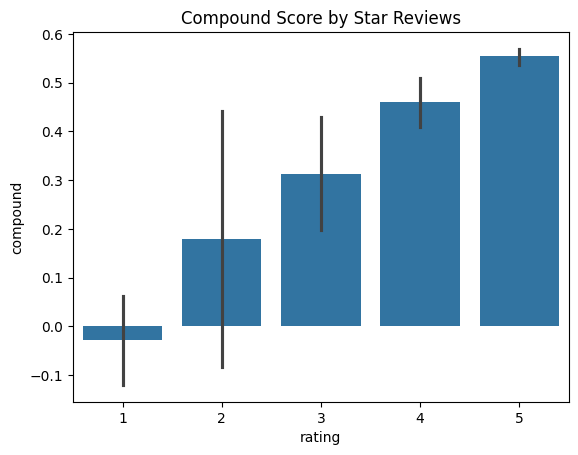

In [11]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title("Compound Score by Star Reviews")

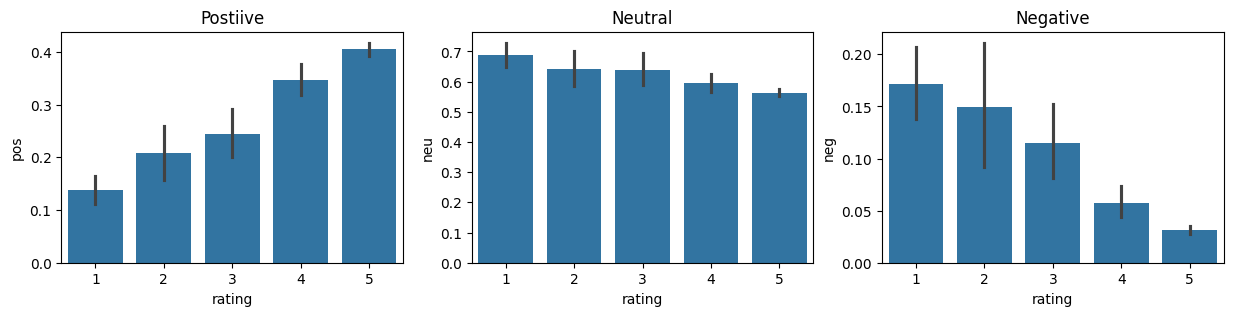

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
sns.barplot(data=vaders, x = "rating", y="pos", ax=axs[0])
sns.barplot(data=vaders, x = "rating", y="neu", ax=axs[1])
sns.barplot(data=vaders, x = "rating", y="neg", ax=axs[2])

axs[0].set_title("Postiive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.tight_layout
plt.show()

In [13]:
# ROBERTA

In [14]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores


array([0.5039586 , 0.45902118, 0.03702018], dtype=float32)

In [16]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output.logits[0].detach().numpy()
scores = softmax(scores)
scores_dict = {
        'roberta_negative': scores[0],
        'roberta_neutral': scores[1],
        'roberta_positive': scores[2]
}
print(scores_dict)

{'roberta_negative': 0.5039586, 'roberta_neutral': 0.45902118, 'roberta_positive': 0.03702018}


In [17]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_negative': scores[0],
        'roberta_neutral': scores[1],
        'roberta_positive': scores[2]
    }
    
    return scores_dict

In [18]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    content = row['content']
    id = row['sno']
    vader_result = sia.polarity_scores(content)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(content)
    both = {**vader_result_rename, **roberta_result}
    res[id] = both
      

  0%|          | 0/2207 [00:00<?, ?it/s]

In [19]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index':'sno'})
results_df = results_df.merge(df, how='left')
results_df


,sno,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,product,title,content,date,author,rating,category
0,1,0.000,0.707,0.293,0.7675,0.017925,0.480386,0.501689,Intel Core I5 12400F 12 Gen Generation Desktop...,great processor,processor power efficient develop android apps...,01-04-2024,ARUN,5,i5
1,2,0.000,1.000,0.000,0.0000,0.154699,0.813829,0.031472,Intel Core I5 12400F 12 Gen Generation Desktop...,got,try get check ranking detail section buying an...,01-05-2024,Ayush,5,i5
2,3,0.157,0.656,0.186,0.3871,0.060161,0.378202,0.561637,Intel Core I5 12400F 12 Gen Generation Desktop...,highest price performance processor gaming,upgrade performance gain huge use cooler maste...,01-03-2024,Hruaia,5,i5
3,4,0.000,0.625,0.375,0.6369,0.014878,0.380326,0.604796,Intel Core I5 12400F 12 Gen Generation Desktop...,nice processor,best aaaaaaaa gaming multitasking processor pr...,01-04-2024,Mr.GeAr,5,i5
4,5,0.000,0.840,0.160,0.2732,0.012524,0.386464,0.601012,Intel Core I5 12400F 12 Gen Generation Desktop...,title,run well productivity task core cpu minimum re...,01-01-2024,Joy Mukherjee,5,i5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,2204,0.000,0.196,0.804,0.6249,0.027750,0.222102,0.750149,Intel Core i3-8100 3.60 GHz Quad-Core (BX80684...,great,great sellworked,01-09-2018,benit-ernes,5,i3
2203,2205,0.000,0.256,0.744,0.4404,0.011240,0.101536,0.887224,Intel Core i3-8100 3.60 GHz Quad-Core (BX80684...,good product,good product,01-06-2018,sandrzubir-0,5,i3
2204,2206,0.000,0.233,0.767,0.7650,0.012291,0.146542,0.841167,Intel Core i3-4160 - 3.6 GHz (SR1PK) Processor,proc great shape worked great,easy install boot perfect,01-12-2017,aceinternetserv...,5,i3
2205,2207,0.000,0.196,0.804,0.6249,0.006942,0.072824,0.920234,Intel Core i3-4160 - 3.6 GHz (SR1PK) Processor,title,work great,01-12-2020,dfce1265,5,i3


In [20]:

results_data = results_df.copy()

In [21]:
def update_vader_predict(row):
    compound_score = row['vader_compound']
    
    if compound_score > 0.9:
        return 'Positive'
    elif compound_score > 0.6:
        return 'Positive'
    elif compound_score > 0.3:
        return 'Positive'
    elif compound_score > 0.05:
        return 'Positive'
    elif compound_score >= -0.05:
        return 'Neutral'
    elif compound_score >= -0.3:
        return 'Negative'
    elif compound_score >= -0.6:
        return 'Negative'
    elif compound_score >= -0.9:
        return 'Negative'
    else:
        return 'Negative'

#Define a function to determine the highest sentiment for the roberta columns
    
def determine_roberta_sentiment(row):
    if row["roberta_positive"] > row['roberta_negative'] and row['roberta_positive'] > row['roberta_neutral']:
        return "Postive"
    elif row["roberta_negative"] > row['roberta_positive'] and row['roberta_negative'] > row['roberta_neutral']:
        return "Negative"
    else:
        return "Neutral"

results_data['vader_sentiment'] = results_data.apply(update_vader_predict, axis=1)
results_data['roberta_predict'] = results_data.apply(determine_roberta_sentiment, axis=1)

In [22]:
pivot_table = results_data.pivot_table(index='rating', columns='vader_sentiment', values='sno', aggfunc='count', fill_value=0)
print(pivot_table)

vader_sentiment  Negative  Neutral  Positive
rating                                      
1                      50       24        46
2                       7        2        11
3                      15        8        41
4                      21       22       184
5                      64      194      1518


In [23]:
pivot_table = results_data.pivot_table(index='rating', columns='roberta_predict', values='sno', aggfunc='count', fill_value=0)
print(pivot_table)

roberta_predict  Negative  Neutral  Postive
rating                                     
1                      47       65        8
2                       7        8        5
3                      12       30       22
4                      11       77      139
5                      24      427     1325


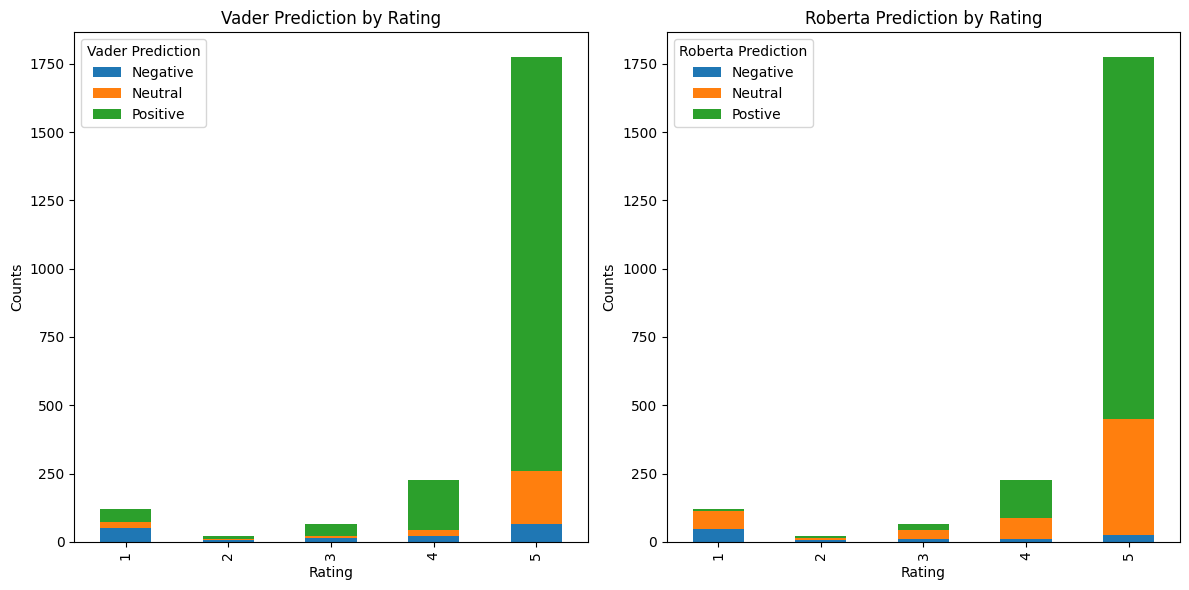

In [24]:
vader_prediction_counts  = results_data.groupby(['rating', 'vader_sentiment']).size().unstack(fill_value=0)
roberta_prediction_counts  = results_data.groupby(['rating', 'roberta_predict']).size().unstack(fill_value=0)

# Assuming axs is defined somewhere in your code
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting Vader Prediction by Rating
vader_prediction_counts.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title("Vader Prediction by Rating")
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Counts')
axs[0].legend(title="Vader Prediction")

# Plotting Roberta Prediction by Rating
roberta_prediction_counts.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title("Roberta Prediction by Rating")
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Counts')
axs[1].legend(title="Roberta Prediction")

plt.tight_layout()
plt.show()

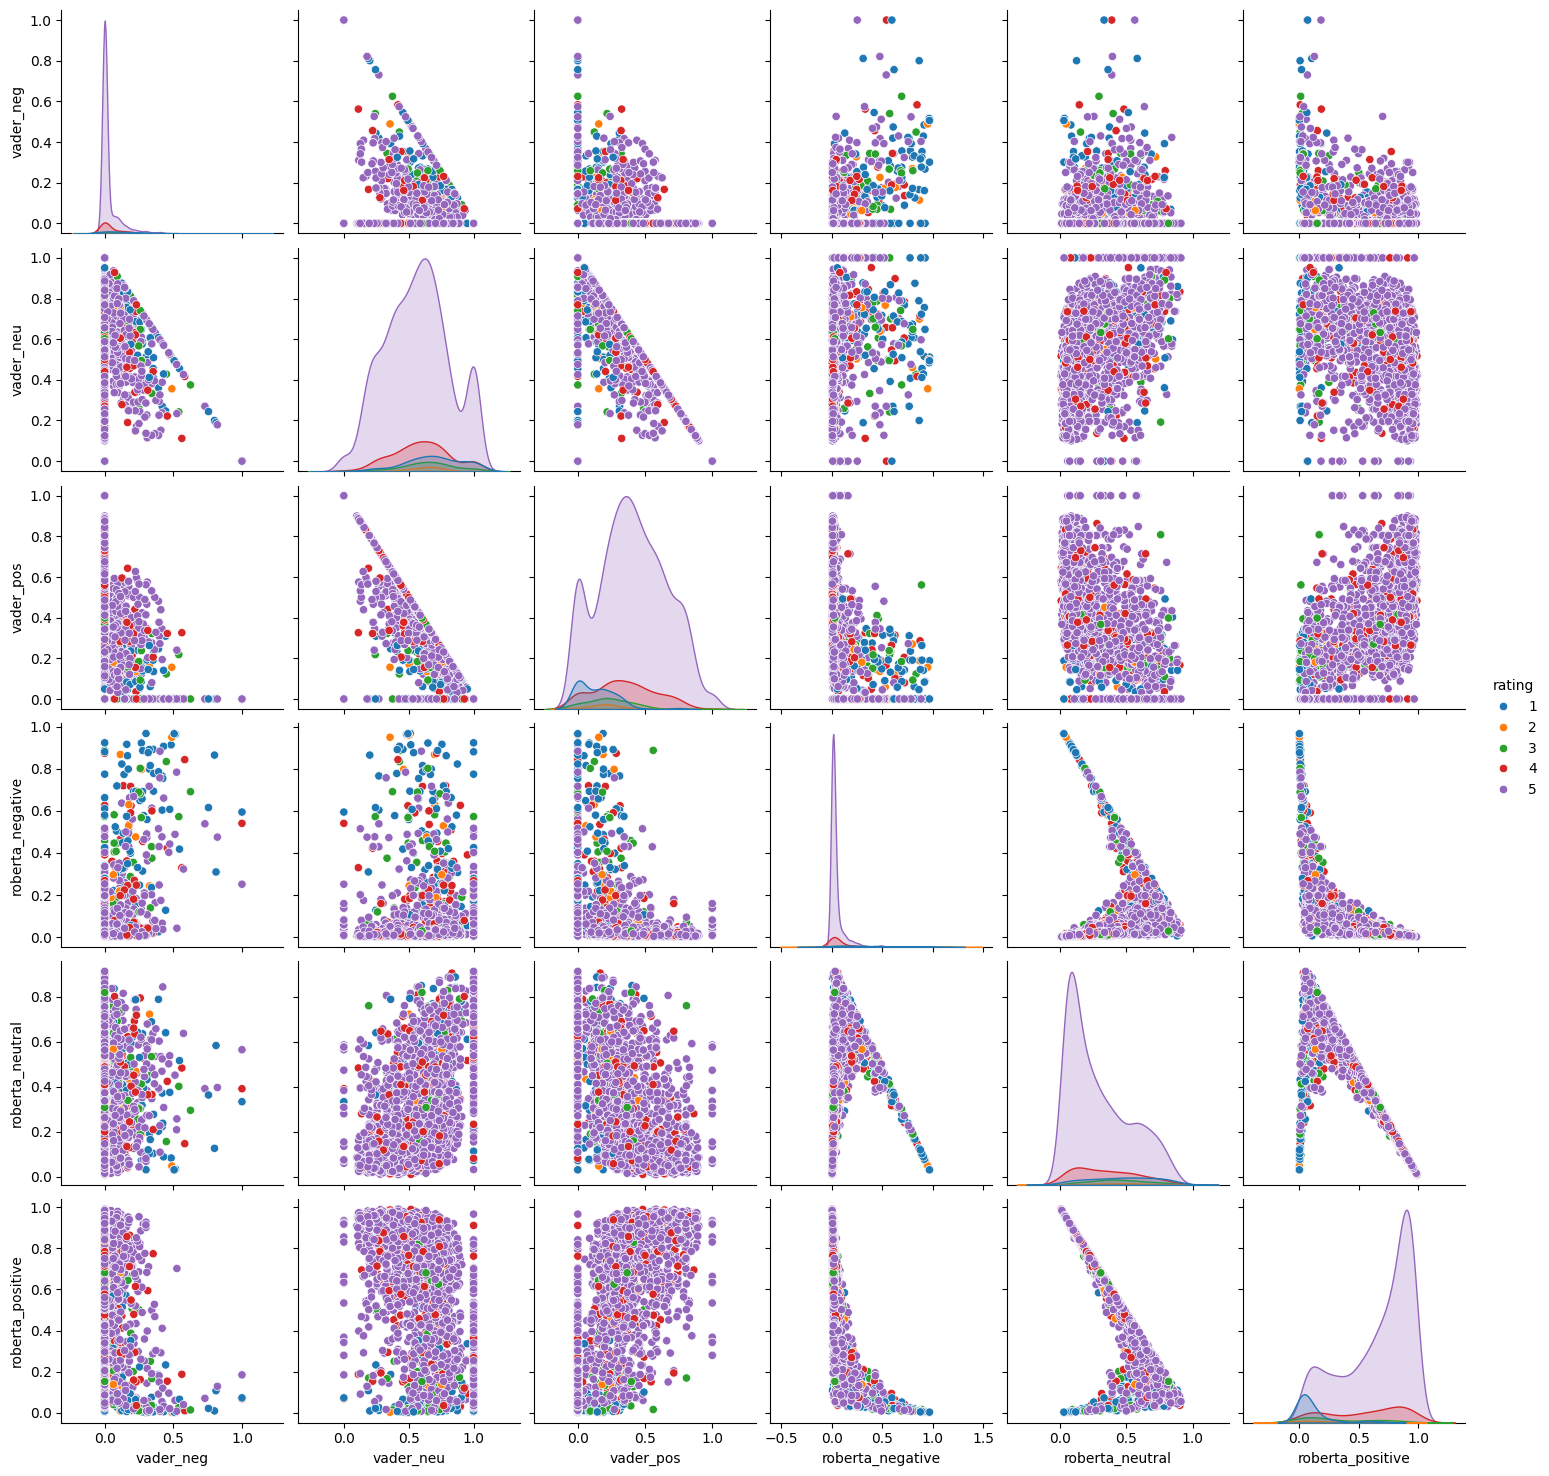

In [25]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_negative', 'roberta_neutral', 'roberta_positive'],
            hue='rating',
            palette='tab10')
plt.show()

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Assuming 'model' is your trained BERT model and 'tokenizer' is the corresponding tokenizer
model_name = "/content/"

# Save the model
model.save_pretrained(model_name)

# Save the tokenizer
tokenizer.save_pretrained(model_name)

print(f"Model and tokenizer saved in {model_name}")

In [25]:
# BERT

In [26]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Define a function to categorize ratings into sentiment classes
def categorize_sentiment(rating):
    if rating in [4, 5]:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the function to create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(categorize_sentiment)

# Map sentiments to numeric labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

# Display the first few rows of the dataset
df.head()

,sno,product,title,content,date,author,rating,category,sentiment,label
0,1,Intel Core I5 12400F 12 Gen Generation Desktop...,great processor,processor power efficient develop android apps...,01-04-2024,ARUN,5,i5,Positive,2
1,2,Intel Core I5 12400F 12 Gen Generation Desktop...,got,try get check ranking detail section buying an...,01-05-2024,Ayush,5,i5,Positive,2
2,3,Intel Core I5 12400F 12 Gen Generation Desktop...,highest price performance processor gaming,upgrade performance gain huge use cooler maste...,01-03-2024,Hruaia,5,i5,Positive,2
3,4,Intel Core I5 12400F 12 Gen Generation Desktop...,nice processor,best aaaaaaaa gaming multitasking processor pr...,01-04-2024,Mr.GeAr,5,i5,Positive,2
4,5,Intel Core I5 12400F 12 Gen Generation Desktop...,title,run well productivity task core cpu minimum re...,01-01-2024,Joy Mukherjee,5,i5,Positive,2


In [27]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        texts=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_data_loader = create_data_loader(df_train, tokenizer, max_len=160, batch_size=16)
val_data_loader = create_data_loader(df_val, tokenizer, max_len=160, batch_size=16)


In [28]:
     # Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_loader.dataset,
    eval_dataset=val_data_loader.dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\asus\.conda\envs\gpu\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\asus\.conda\envs\gpu\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.383100,0.332739,0.907240,0.863115,0.823084,0.907240
2,0.306000,0.288440,0.907240,0.885830,0.868741,0.907240
3,0.119700,0.434042,0.920814,0.895794,0.888616,0.920814
4,0.309800,0.312972,0.902715,0.893704,0.885880,0.902715
5,0.167900,0.384503,0.925339,0.908875,0.895555,0.925339


C:\Users\asus\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\.conda\envs

Evaluation results: {'eval_loss': 0.3845028281211853, 'eval_accuracy': 0.9253393665158371, 'eval_f1': 0.9088747233873897, 'eval_precision': 0.8955546479509034, 'eval_recall': 0.9253393665158371, 'eval_runtime': 3.2602, 'eval_samples_per_second': 135.576, 'eval_steps_per_second': 8.589, 'epoch': 5.0}


In [29]:
# Evaluate the model
trainer.evaluate()


{'eval_loss': 0.3845028281211853,
 'eval_accuracy': 0.9253393665158371,
 'eval_f1': 0.9088747233873897,
 'eval_precision': 0.8955546479509034,
 'eval_recall': 0.9253393665158371,
 'eval_runtime': 3.2766,
 'eval_samples_per_second': 134.896,
 'eval_steps_per_second': 8.545,
 'epoch': 5.0}

In [57]:

def analyze_review(text):
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    device = torch.device("cuda")
    model.to('cuda')
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    sentiment = torch.argmax(probabilities, dim=1).item()
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    probabilities = probabilities.squeeze().tolist()
    formatted_probabilities = {
        'Negative': f"{probabilities[0]:.2f}",
        'Neutral': f"{probabilities[1]:.2f}",
        'Positive': f"{probabilities[2]:.2f}"
    }

    return sentiment_map[sentiment], formatted_probabilities
def highlight_sentiment(text):
    doc = nlp(text)
    positive_parts = []
    negative_parts = []
    neutral_parts = []
    improvements = []

    for sent in doc.sents:
        sentiment, _ = analyze_review(sent.text)
        if sentiment == 'Positive':
            positive_parts.append(sent.text)
        elif sentiment == 'Negative':
            negative_parts.append(sent.text)
            for word in sent.text.split():
                word_lower = word.lower()
                if word_lower in improvement_suggestions:
                    improvements.append(improvement_suggestions[word_lower])
        else:
            neutral_parts.append(sent.text)

    return {
        'positive_parts': ' '.join(positive_parts),
        'negative_parts': ' '.join(negative_parts),
        'neutral_parts': ' '.join(neutral_parts),
        'improvements': list(set(improvements))
    }

In [1]:
## CONTINUED BERT MODEL IN BERT_final.ipynb